In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from mpl_toolkits import mplot3d
import matplotlib as mpl
import torch  
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading data
absolute_path="drive/My Drive/ESE 545/Project2/"
test_images=np.load(absolute_path+"test.npy")
train_images=np.load(absolute_path+"train.npy")
test_labels=np.load(absolute_path+"test_labels.npy")
train_labels=np.load(absolute_path+"train_labels.npy")

In [ ]:
#analyze data
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


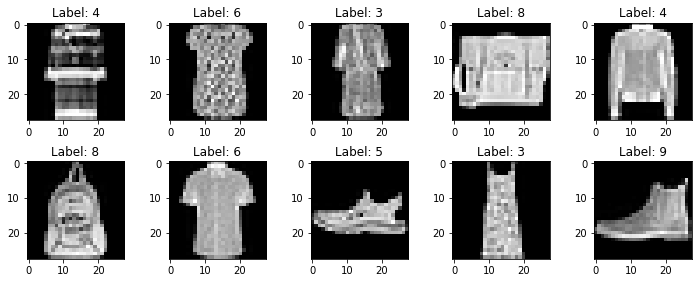

In [ ]:
def show_class(train_images, train_labels):
  rand_indices=np.random.randint(0,18000,10)
  fig = plt.figure(figsize=(10,4))

  i = 1
  for r in rand_indices:
    ax = fig.add_subplot(2,5,i)
    ax.imshow(train_images[r], cmap = 'gray')
    ax.set_title('Label: {}'.format(train_labels[r]))
    i += 1
    
  fig.tight_layout()
  plt.show()

In [ ]:
# getting data from classes 2, 5 and 7
filtered257_train_images=train_images[(train_labels==2) + (train_labels ==5) + (train_labels==7)]
filtered257_train_labels=train_labels[(train_labels==2) + (train_labels ==5) + (train_labels==7)]
filtered257_test_images=test_images[(test_labels==2) + (test_labels ==5) + (test_labels==7)]
filtered257_test_labels=test_labels[(test_labels==2) + (test_labels==5) + (test_labels==7)]

#modifications for part 6
train257_images_torch = filtered257_train_images.reshape(-1,1, filtered257_train_images.shape[1], filtered257_train_images.shape[2])
train257_labels_torch = filtered257_train_labels.reshape(-1,1)
train257_images_torch = Variable(torch.from_numpy(train257_images_torch))
train257_labels_torch = Variable(torch.from_numpy(train257_labels_torch))

#flattening and appending 1 for bias to the inputs
filtered257_train_images=filtered257_train_images.reshape(filtered257_train_images.shape[0],-1)
filtered257_test_images=filtered257_test_images.reshape(filtered257_test_images.shape[0],-1)
filtered257_train_images=np.hstack((filtered257_train_images,np.ones((filtered257_train_images.shape[0],1))))
filtered257_test_images=np.hstack((filtered257_test_images,np.ones((filtered257_test_images.shape[0],1))))

#reshaping labels from (x,) to (x,1) for matrix multiplication
filtered257_train_labels=filtered257_train_labels.reshape((-1,1))
filtered257_test_labels=filtered257_test_labels.reshape((-1,1))


In [ ]:
#splitting data in two classes for binary classifications, and assigning labels of the two classes as -1 and +1
# also required for one vs one multiclassification
filtered25_train_images=filtered257_train_images[(filtered257_train_labels.flatten()==2)+(filtered257_train_labels.flatten()==5)]
filtered25_train_labels=filtered257_train_labels[(filtered257_train_labels.flatten()==2)+(filtered257_train_labels.flatten()==5)]
filtered25_test_images=filtered257_test_images[(filtered257_test_labels.flatten()==2)+(filtered257_test_labels.flatten()==5)]
filtered25_test_labels=filtered257_test_labels[(filtered257_test_labels.flatten()==2)+(filtered257_test_labels.flatten()==5)]
filtered25_test_labels[filtered25_test_labels==2]=1
filtered25_test_labels[filtered25_test_labels==5]=-1
filtered25_train_labels[filtered25_train_labels==2]=1
filtered25_train_labels[filtered25_train_labels==5]=-1

filtered27_train_images=filtered257_train_images[(filtered257_train_labels.flatten()==2)+(filtered257_train_labels.flatten()==7)]
filtered27_train_labels=filtered257_train_labels[(filtered257_train_labels.flatten()==2)+(filtered257_train_labels.flatten()==7)]
filtered27_test_images=filtered257_test_images[(filtered257_test_labels.flatten()==2)+(filtered257_test_labels.flatten()==7)]
filtered27_test_labels=filtered257_test_labels[(filtered257_test_labels.flatten()==2)+(filtered257_test_labels.flatten()==7)]
filtered27_test_labels[filtered27_test_labels==7]=1
filtered27_test_labels[filtered27_test_labels==2]=-1
filtered27_train_labels[filtered27_train_labels==7]=1
filtered27_train_labels[filtered27_train_labels==2]=-1

filtered57_train_images=filtered257_train_images[(filtered257_train_labels.flatten()==5)+(filtered257_train_labels.flatten()==7)]
filtered57_train_labels=filtered257_train_labels[(filtered257_train_labels.flatten()==5)+(filtered257_train_labels.flatten()==7)]
filtered57_test_images=filtered257_test_images[(filtered257_test_labels.flatten()==5)+(filtered257_test_labels.flatten()==7)]
filtered57_test_labels=filtered257_test_labels[(filtered257_test_labels.flatten()==5)+(filtered257_test_labels.flatten()==7)]
filtered57_test_labels[filtered57_test_labels==5]=1
filtered57_test_labels[filtered57_test_labels==7]=-1
filtered57_train_labels[filtered57_train_labels==5]=1
filtered57_train_labels[filtered57_train_labels==7]=-1

In [ ]:
def init_pegasos(reg_param, num_iter, batch_size):
  regularizn_param=reg_param
  num_iter=num_iter
  batch_size=batch_size
  w_limit=1/(np.sqrt(regularizn_param))
  return regularizn_param, num_iter, batch_size, w_limit

In [ ]:
def calc_project(w_t,w_limit):
  if(np.linalg.norm(w_t)>w_limit):
    return w_t*w_limit/np.linalg.norm(w_t)
  else:
    return w_t

In [ ]:
def calc_binary_accuracy(w_25, sample_images, sample_labels):
  vec_hat_25 = (sample_images@w_25)
  pred=np.copy(vec_hat_25)
  pred[pred>0]=1
  pred[pred<0]=-1
  print(pred==sample_labels)
  print((np.sum(pred==sample_labels))/len(pred))

In [ ]:
# PEGASOS
def pegasos(batch_size, reg):
  regularizn_param, num_iter, batch_size, w_limit = init_pegasos(reg, 4000, batch_size)
  num_iter = 4000
  w_t=np.random.rand(filtered25_train_images.shape[1])
  w_t=w_t.reshape((-1,1))
  w_t=calc_project(w_t,w_limit)
  train=[]
  test=[]
  for itr in range(1,num_iter):
    eta=1/(regularizn_param*itr)
    batch_indices=np.random.randint(0,filtered25_train_images.shape[0],batch_size)
    values=(filtered25_train_images[batch_indices]@w_t)*(filtered25_train_labels[batch_indices])
    values=values.flatten()
    msclsfd_indices=batch_indices[(values<1)]
    msclsfd_labels=filtered25_train_labels[msclsfd_indices]
    msclsfd_images=filtered25_train_images[msclsfd_indices]
    temep=(msclsfd_images*msclsfd_labels) 
    temp=np.sum(temep,axis=0)
    temp=temp.reshape((-1,1))
    delta = (regularizn_param*w_t) - ((1/batch_size)*temp)
    delta=eta*delta
    w_t=w_t-(delta)
    w_t=calc_project(w_t,w_limit)

    vals=((filtered25_train_images@w_t)*(filtered25_train_labels)).flatten()
    train.append(1- (len(vals[vals>1])/len(filtered25_train_labels)))
    vals1=((filtered25_test_images@w_t)*(filtered25_test_labels)).flatten()
    test.append(1- (len(vals1[vals1>1])/len(filtered25_test_labels)))
  return w_t, train, test
    # if(itr%100==99):
    #   print("iter "+str(itr))

In [ ]:
def pegasos_batch_size_tune():
  batch_sizes=[50,100,500, 1000, 3000, 6000]
  regularizations = [0.01, 0.05, 0.1, 0.5,1]
  batch_train_error = []
  batch_test_error = []
  for b in range(len(batch_sizes)):
    start = time.time()
    w, train, test = pegasos(batch_sizes[b],1)
    batch_train_error.append(train)
    batch_test_error.append(test)
    print('Batch size: {}; Running time: {}; Final Test Error.{}'.format(batch_sizes[b], time.time()-start, test[-1]))

  for b in range(len(batch_sizes)):
    plt.plot(batch_train_error[b])
  # plt.xticks(k11, x)
  plt.ylabel('PEGASOS_Train_Error')
  plt.xlabel('No. of Iteration')
  plt.title("PEGASOS Train Error vs. Batch Size")
  plt.legend(['batch sizes:50', 'batch size:100','batch size:500', 'batch size:1000','batch size:3000', 'batch size:6000'])
  plt.savefig('training_error')
  plt.show()


  for b in range(len(batch_sizes)):
    plt.plot(batch_test_error[b])
  plt.ylabel('PEGASOS_Test_Error')
  plt.xlabel('No. of Iteration')
  plt.title("PEGASOS Test Error vs. Batch Size")
  plt.legend(['batch sizes:50', 'batch size:100','batch size:500', 'batch size:1000','batch size:3000', 'batch size:6000'])
  plt.savefig('test_error')
  plt.show()

def pegasos_batch_regularizations_parameter():
  # visualize regularization parameter
  regu_train_error = []
  regu_test_error = []
  for b in range(len(regularizations)):
    start = time.time()
    w, train, test = pegasos(50,regularizations[b])
    regu_train_error.append(train)
    regu_test_error.append(test)
    print('Regularization parameter: {}; Running time: {}; Final Test Error.{}'.format(regularizations[b], time.time()-start, test[-1]))

  for b in range(len(regularizations)):
    plt.plot(regu_train_error[b])
  # plt.xticks(k11, x)
  plt.ylabel('PEGASOS_Train_Error')
  plt.xlabel('No. of Iteration')
  plt.title("PEGASOS Train Error vs. Regularization parameter")
  # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend(['Regularization parameter:0.01', 'Regularization parameter:0.05','Regularization parameter:0.1', 'Regularization parameter:0.5','Regularization parameter:1'],bbox_to_anchor=(1,1))
  plt.show()

  for b in range(len(regularizations)):
    plt.plot(regu_test_error[b])
  plt.ylabel('PEGASOS_Test_Error')
  plt.xlabel('No. of Iteration')
  plt.title("PEGASOS Test Error vs. Regularization parameter")
  plt.legend(['Regularization parameter:0.01', 'Regularization parameter:0.05','Regularization parameter:0.1', 'Regularization parameter:0.5','Regularization parameter:1'],bbox_to_anchor=(1,1))
  plt.show()


In [ ]:
def pegasos_plot(train, test):
  plt.ylabel('PEGASOS_Train_Error')
  plt.xlabel('No. of Iteration')
  plt.title("PEGASOS Train Error")
  plt.plot(train) 
  plt.show()
  plt.ylabel('PEGASOS_Test_Error')
  plt.xlabel('No. of Iteration')
  plt.title("PEGASOS Test Error")
  plt.plot(test) 
  plt.show()

In [ ]:
def init_adagrad(num_iter, stepsize, batch_size):
  num_iter = num_iter
  fudge_factor = 1e-6
  stepsize = stepsize
  batch_size = batch_size
  return num_iter, fudge_factor, stepsize, batch_size

In [ ]:
def calc_multiclass_w_adagrad(train_image, image_label, w, batch_size, grad, y, stepsize, gti, fudge_factor):
    idx = np.random.randint(0,train_image.shape[0],batch_size)
    zero_arr = np.zeros((batch_size,1))
    y_hat = np.dot(train_image[idx,:],w)
    v = image_label[idx,:]*y_hat
    y_hat[y_hat<0] = -1
    y_hat[y_hat>0] = 1
    loss_matrix = np.maximum(zero_arr,(1-v))
    loss = np.average(loss_matrix)
    # if i%100 == 0:
    # #   ada_train_error_arr.append(tarin_error)
    # #   print('iteration: {} -> train_error: {}'.format(i, tarin_error))
    #   print('iteration: {} -> train_loss: {}'.format(i, loss))
    v = v.reshape(-1)
    grad_idx = np.where(v<1)
    grad[grad_idx,:] = -y[grad_idx,:] * train_image[grad_idx, :]
    grad_val = np.average(grad, axis = 0)
    grad_val = grad_val.reshape(-1,1)
    w = w - stepsize*grad_val
    gti += grad_val**2
    adjusted_grad = grad_val / (fudge_factor + np.sqrt(gti))
    w = w - stepsize*adjusted_grad
    return w, grad, gti, loss

In [ ]:
def calc_multiclass_accuracy(w_25, w_27, w_57, multiclass_sample_images, multiclass_sample_labels):  
  vec_hat_25= np.dot(multiclass_sample_images, w_25)
  vec_hat_27= np.dot(multiclass_sample_images, w_27)
  vec_hat_57= np.dot(multiclass_sample_images, w_57)
  results = np.empty((vec_hat_25.shape))
  # print(vec_hat_25)
  neg_flg=0
  for i in range(vec_hat_25.shape[0]):  
    if((vec_hat_25[i]>0) and (vec_hat_27[i]>0) and (vec_hat_57[i]<0)):
      results[i]=7
    elif((vec_hat_25[i]>0) and (vec_hat_27[i]<0) and (vec_hat_57[i]>0)):
      results[i]=2
    elif((vec_hat_25[i]>0) and (vec_hat_27[i]<0) and (vec_hat_57[i]<0)):
      results[i]=2
    elif((vec_hat_25[i]<0) and (vec_hat_27[i]>0) and (vec_hat_57[i]>0)):
      results[i]=5
    elif((vec_hat_25[i]<0) and (vec_hat_27[i]>0) and (vec_hat_57[i]<0)):
      results[i]=7
    elif((vec_hat_25[i]<0) and (vec_hat_27[i]<0) and (vec_hat_57[i]>0)):
      results[i]=5
    else:
    # if((vec_hat_25[i])<0 and (vec_hat_27[i])<0 and (vec_hat_57[i])<0)
    # if((vec_hat_25[i])>0 and (vec_hat_27[i])>0 and (vec_hat_57[i])>0)
      x=np.empty((3))
      x[0]=vec_hat_25[i]
      x[1]=vec_hat_27[i]
      x[2]=vec_hat_57[i]
      if(x[0]<0):
        x=x*-1
        neg_flg=1
      idx=np.argmax(x)
      if(idx==0):
        if(neg_flg==1):
          results[i]=5
        else:
          results[i]=2
      elif(idx==1):
        if(neg_flg==1):
          results[i]=2
        else:
          results[i]=7
      elif(idx==2):
        if(neg_flg==1):
          results[i]=7
        else:
          results[i]=5
  # results=np.reshape(results,(-1,1))
  # print(np.sum(results!=multiclass_sample_labels)/len(results))
  return (np.sum(results!=multiclass_sample_labels)/len(results))

In [ ]:
def multiclass_classifier_adagrad(filtered25_train_images,filtered27_train_images,filtered57_train_images,filtered25_train_labels,filtered27_train_labels,filtered57_train_labels):
  num_iter, fudge_factor, stepsize, batch_size = init_adagrad(200, 10, 800)
  w_25=(np.random.rand(filtered25_train_images.shape[1])).reshape((-1,1))
  w_27=(np.random.rand(filtered27_train_images.shape[1])).reshape((-1,1))
  w_57=(np.random.rand(filtered57_train_images.shape[1])).reshape((-1,1))
  
  gti_25=np.ones((filtered25_train_images.shape[1],1))
  gti_27=np.ones((filtered27_train_images.shape[1],1))
  gti_57=np.ones((filtered57_train_images.shape[1],1))

  grad_25 = np.zeros((batch_size,filtered25_train_images.shape[1]))
  grad_27 = np.zeros((batch_size,filtered27_train_images.shape[1]))
  grad_57 = np.zeros((batch_size,filtered57_train_images.shape[1]))
  y_25 = filtered25_train_labels
  y_25 = np.repeat(y_25,filtered25_train_images.shape[1],axis = 1)
  y_27 = filtered27_train_labels
  y_27 = np.repeat(y_27,filtered27_train_images.shape[1],axis = 1)
  y_57 = filtered57_train_labels
  y_57 = np.repeat(y_57,filtered57_train_images.shape[1],axis = 1)
  row_sums_25 = filtered25_train_images.sum(axis=1)
  filtered25_train_images = filtered25_train_images / row_sums_25[:, np.newaxis]
  row_sums_27 = filtered27_train_images.sum(axis=1)
  filtered27_train_images = filtered27_train_images / row_sums_27[:, np.newaxis]
  row_sums_57 = filtered57_train_images.sum(axis=1)
  filtered57_train_images = filtered57_train_images / row_sums_57[:, np.newaxis]
  train=[]
  test=[]
  for itr in range(1,num_iter):
    w_25, grad_25, gti_25, loss_25=calc_multiclass_w_adagrad(filtered25_train_images, filtered25_train_labels, w_25, batch_size, grad_25, y_25, stepsize, gti_25, fudge_factor)
    w_27, grad_27, gti_27, loss_27=calc_multiclass_w_adagrad(filtered27_train_images, filtered27_train_labels, w_27, batch_size, grad_27, y_27, stepsize, gti_27, fudge_factor)
    w_57, grad_57, gti_57, loss_57=calc_multiclass_w_adagrad(filtered57_train_images, filtered57_train_labels, w_57, batch_size, grad_57, y_57, stepsize, gti_57, fudge_factor)
    train.append(calc_multiclass_accuracy(w_25, w_27, w_57, filtered257_train_images, filtered257_train_labels))
    test.append(calc_multiclass_accuracy(w_25, w_27, w_57, filtered257_test_images, filtered257_test_labels)) 

    # if(itr%50==0):
    #   print("____________________________________________________________________")
    #   print('iteration: {} -> train_loss_25: {}'.format(itr, loss_25))
    #   print('iteration: {} -> train_loss_27: {}'.format(itr, loss_27))
    #   print('iteration: {} -> train_loss_57: {}'.format(itr, loss_57))
    
  return train, test

In [ ]:
def calc_w_adagrad(train_image, image_label, w, batch_size, grad, y, stepsize, gti, fudge_factor):
    idx = np.random.randint(0,train_image.shape[0],batch_size)
    zero_arr = np.zeros((batch_size,1))
    y_hat = np.dot(train_image[idx,:],w)
    v = image_label[idx,:]*y_hat
    y_hat[y_hat<0] = -1
    y_hat[y_hat>0] = 1
    loss_matrix = np.maximum(zero_arr,1-v)
    loss = np.average(loss_matrix)
    tarin_error = np.sum(y_hat!=filtered25_train_labels[idx,:])/batch_size
    # if i%100 == 0:
    # #   ada_train_error_arr.append(tarin_error)
    # #   print('iteration: {} -> train_error: {}'.format(i, tarin_error))
    #   print('iteration: {} -> train_loss: {}'.format(i, loss))
    v = v.reshape(-1)
    grad_idx = np.where(v<1)
    grad[grad_idx,:] = -y[grad_idx,:] * train_image[grad_idx, :]
    grad_val = np.average(grad, axis = 0)
    grad_val = grad_val.reshape(-1,1)
    w = w - stepsize*grad_val
    gti += grad_val**2
    adjusted_grad = grad_val / (fudge_factor + np.sqrt(gti))
    w = w - stepsize*adjusted_grad
    return w, grad, gti, loss, tarin_error

In [ ]:
def adagrad(filtered25_train_images,filtered25_train_labels, num_iter, stepsize, batch_size):
  num_iter, fudge_factor, stepsize, batch_size = init_adagrad(num_iter, stepsize, batch_size)
  w_25=(np.random.rand(filtered25_train_images.shape[1])).reshape((-1,1)) 
  gti_25=np.ones((filtered25_train_images.shape[1],1))
  grad_25 = np.zeros((batch_size,filtered25_train_images.shape[1]))
  y_25 = filtered25_train_labels
  y_25 = np.repeat(y_25,filtered25_train_images.shape[1],axis = 1)
  row_sums_25 = filtered25_train_images.sum(axis=1)
  filtered25_train_images = filtered25_train_images / row_sums_25[:, np.newaxis]
  ada_train_error_arr = []
  ada_test_error_arr = []
  for itr in range(0,num_iter):
    w_25, grad_25, gti_25, loss, tarin_error=calc_w_adagrad(filtered25_train_images, filtered25_train_labels, w_25, batch_size, grad_25, y_25, stepsize, gti_25, fudge_factor)
    # if((itr%20)==0):
    y_hat = np.dot(filtered25_train_images,w_25)
    y_hat[y_hat<0] = -1
    y_hat[y_hat>0] = 1
    test_error = np.sum(y_hat!=filtered25_train_labels)/filtered25_train_images.shape[0]
    ada_train_error_arr.append(tarin_error)
    # print('iteration: {} -> train_error: {}'.format(itr, tarin_error))
    # print('iteration: {} -> train_loss: {}'.format(itr, loss))      
    y_hat = np.dot(filtered25_test_images,w_25)
    y_hat[y_hat<0] = -1
    y_hat[y_hat>0] = 1
    test_error = np.sum(y_hat!=filtered25_test_labels)/filtered25_test_images.shape[0]
    ada_test_error_arr.append(test_error)
      # print('test_error: {}'.format(test_error))
  return ada_train_error_arr, ada_test_error_arr

In [ ]:
def ada_grad_plot(ada_train_error_arr, ada_test_error_arr):
  plt.plot(ada_train_error_arr)

  # plt.xticks(k11, x)
  plt.ylabel('Adagrad_Train_Error')
  plt.xlabel('No. of Iteration')
  plt.title("Adagrad Train Error")
  plt.savefig('training_error')
  plt.show()


  plt.plot(ada_test_error_arr)
  plt.ylabel('Adagrad_Test_Error')
  plt.xlabel('No. of Iteration')
  plt.title("Adagrad Test Error")
  plt.savefig('test_error')
  plt.show()


In [ ]:
# Q3. Parameter Tuning
def ada_step_size_tune():
  ada_train_error_arr_step_size = [5,6,7,8,9,10]

  step_train_error = []
  step_test_error = []
  x = np.arange(0,1000,20)
  for b in range(len(ada_train_error_arr_step_size)):
    start = time.time()
    train, test = adagrad(filtered25_train_images,filtered25_train_labels, 1000, ada_train_error_arr_step_size[b], 800)
    step_train_error.append(train)
    step_test_error.append(test)
    print('Step size: {}; Running time: {}; Final Test Error.{}'.format(ada_train_error_arr_step_size[b], time.time()-start, test[-1]))

  for b in range(len(ada_train_error_arr_step_size)):
    plt.plot(step_train_error[b])

  plt.ylabel('Adagrad_Train_Error')
  plt.xlabel('No. of Iteration')
  plt.title("Adagrad Train Error vs. Step Size")
  plt.legend(['step size:5', 'step size:6','step size:7', 'step size:8','step size:9', 'step size:10'])
  plt.show()

  for b in range(len(ada_train_error_arr_step_size)):
    plt.plot(step_test_error[b])
    
  plt.ylabel('Adagrad_Test_Error')
  plt.xlabel('No. of Iteration')
  plt.title("Adagrad Test Error vs. Step Size")
  plt.legend(['step size:5', 'step size:6','step size:7', 'step size:8','step size:9', 'step size:10'])
  plt.show()

In [ ]:
# Q3. Parameter Tuning
def ada_batch_size_tune():
  ada_train_error_arr_batch_size = [200,400,600,800,1000,2000]

  batch_train_error = []
  batch_test_error = []
  x = np.arange(0,1000,20)
  for b in range(len(ada_train_error_arr_batch_size)):
    start = time.time()
    train, test = adagrad(filtered25_train_images,filtered25_train_labels, 1000, 10, ada_train_error_arr_batch_size[b])
    batch_train_error.append(train)
    batch_test_error.append(test)
    print('Batch size: {}; Running time: {}; Final Test Error.{}'.format(ada_train_error_arr_batch_size[b], time.time()-start, test[-1]))

  for b in range(len(ada_train_error_arr_batch_size)):
    plt.plot(batch_train_error[b])

  plt.ylabel('Adagrad_Train_Error')
  plt.xlabel('No. of Iteration')
  plt.title("Adagrad Train Error vs. Batch Size")
  plt.legend(['batch size:200', 'batch size:400','batch size:600', 'batch size:800','batch size:1000', 'batch size:2000'])
  plt.savefig('training_error')
  plt.show()

  for b in range(len(ada_train_error_arr_batch_size)):
    plt.plot(batch_test_error[b])
    
  plt.ylabel('Adagrad_Test_Error')
  plt.xlabel('No. of Iteration')
  plt.title("Adagrad Test Error vs. Batch Size")
  plt.legend(['batch size:200', 'batch size:400','batch size:600', 'batch size:800','batch size:1000', 'batch size:2000'])
  plt.savefig('test_error')
  plt.show()


In [ ]:
# getting data from classes 2, 5 and 7
filtered257_torch_train_images=train_images[(train_labels==2) + (train_labels ==5) + (train_labels==7)]
filtered257_torch_train_labels=train_labels[(train_labels==2) + (train_labels ==5) + (train_labels==7)]
filtered257_torch_test_images=test_images[(test_labels==2) + (test_labels ==5) + (test_labels==7)]
filtered257_torch_test_labels=test_labels[(test_labels==2) + (test_labels==5) + (test_labels==7)]
filtered257_torch_train_labels[filtered257_torch_train_labels == 2] = 0
filtered257_torch_train_labels[filtered257_torch_train_labels == 5] = 1
filtered257_torch_train_labels[filtered257_torch_train_labels == 7] = 2
filtered257_torch_test_labels[filtered257_torch_test_labels == 2] = 0
filtered257_torch_test_labels[filtered257_torch_test_labels == 5] = 1
filtered257_torch_test_labels[filtered257_torch_test_labels == 7] = 2

In [ ]:
BATCH_SIZE = 100
LR = 0.005
NUM_CLASS = 3
Train_epoch = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 0 -> 2; 1 -> 5; 2 -> 7
CLASS_CLOTHING = {0 :'Pullover',
                  1 :'Sandal',
                  2 :'Sneaker'}

class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, image_data, label_data, transform = None):
        self.transform = transform
        self.label = label_data
        self.img = image_data.reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)

        return label, img

    def __len__(self):
        return len(self.label)

My_transform = transforms.Compose([
    transforms.ToTensor(),# default : range [0, 255] -> [0.0,1.0]
])

Train_data = MyDataset(filtered257_torch_train_images, filtered257_torch_train_labels, transform=My_transform)
Test_data = MyDataset(filtered257_torch_test_images, filtered257_torch_test_labels, transform=My_transform)
Train_dataloader = DataLoader(dataset=Train_data, batch_size = BATCH_SIZE, shuffle=False)
Test_dataloader = DataLoader(dataset=Test_data, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
class My_Model(nn.Module):
    def __init__(self, num_of_class):
        super(My_Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.fc1 = nn.Linear(10816, 64)
        self.fc2 = nn.Linear(64, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
def train():
    model = My_Model(NUM_CLASS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    criterion = nn.CrossEntropyLoss()
    train_correct = 0
    train_total = 0
    train_error = []
    for epoch in range(1, Train_epoch + 1):
        for batch_id, (label, image) in enumerate(Train_dataloader):
            label, image = label.to(device), image.to(device)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = torch.argmax(output,dim=1)
            train_total += label.size(0)
            train_correct += (predicted == label).sum().item()
            train_error.append(100 - 100 * train_correct / train_total)

            if batch_id % 10 == 0:
                print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, Train_epoch))
                print('Train Error of the model on the training images: {} %'.format(100 - 100 * train_correct / train_total))
    return model, train_error

In [ ]:
def test(model):
    test_error = []
    with torch.no_grad():
        test_correct = 0
        test_total = 0
        
        for label , image in Test_dataloader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            predicted = torch.argmax(outputs,dim=1)
            test_total += label.size(0)
            test_correct += (predicted == label).sum().item()
            test_error.append(100 - (100 * test_correct / test_total))
        print('Test Error of the model on the test images: {} %'.format(100 - (100 * test_correct / test_total)))
    return test_error

In [ ]:
def cnn_plot(train_error, test_error):
  plt.plot(np.squeeze(train_error))
  plt.ylabel('Training_Error')
  plt.xlabel('No. of Weight Updates')
  plt.title("Training Error")
  plt.savefig('training_error')
  plt.show()
  np.savetxt("Training_Error.csv", train_error, delimiter=",")
  plt.plot(np.squeeze(test_error))
  plt.ylabel('Testing_Error')
  plt.xlabel('No. of Weight Updates')
  plt.title("Testing Error")
  plt.savefig('Testing_error')
  plt.show()
  np.savetxt("Testing_Error.csv", test_error, delimiter=",")

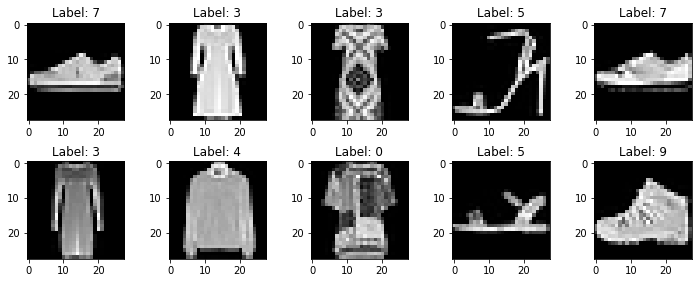

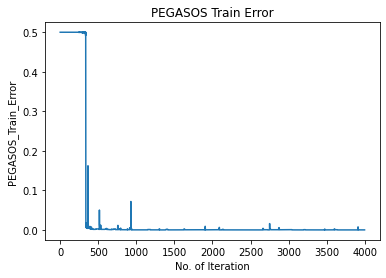

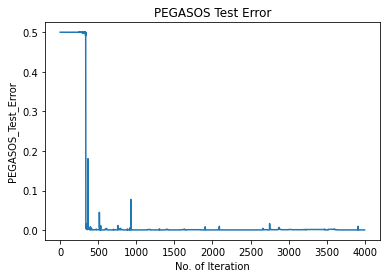

Batch size: 50; Running time: 24.390482187271118; Final Test Error.0.0004999999999999449
Batch size: 100; Running time: 24.980939626693726; Final Test Error.0.0004999999999999449
Batch size: 500; Running time: 29.508747577667236; Final Test Error.0.0014999999999999458
Batch size: 1000; Running time: 34.612932205200195; Final Test Error.0.0014999999999999458
Batch size: 3000; Running time: 55.68571877479553; Final Test Error.0.0014999999999999458
Batch size: 6000; Running time: 92.80928111076355; Final Test Error.0.0014999999999999458


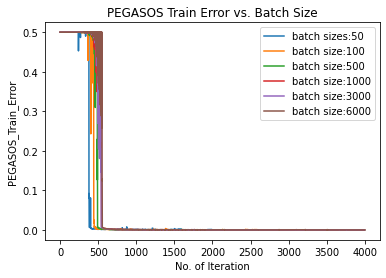

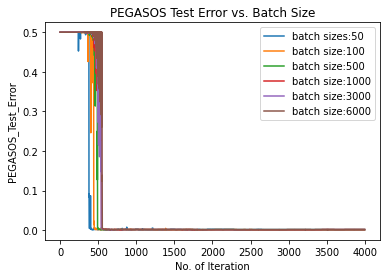

Regularization parameter: 0.01; Running time: 26.63620901107788; Final Test Error.0.22599999999999998
Regularization parameter: 0.05; Running time: 25.895110845565796; Final Test Error.0.0010000000000000009
Regularization parameter: 0.1; Running time: 26.91294813156128; Final Test Error.0.0010000000000000009
Regularization parameter: 0.5; Running time: 26.67962908744812; Final Test Error.0.0004999999999999449
Regularization parameter: 1; Running time: 27.067098379135132; Final Test Error.0.0010000000000000009


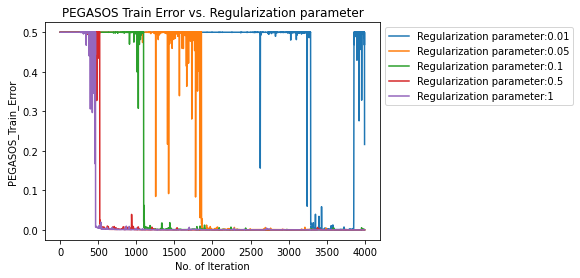

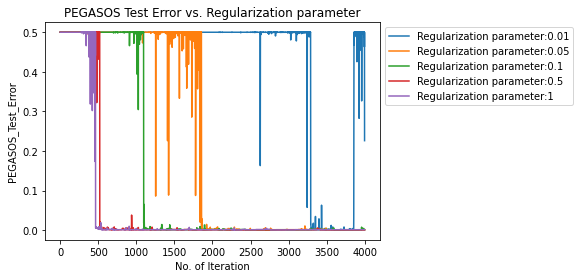

NameError: ignored

In [ ]:
# Problem 1 
show_class(train_images, train_labels)

# Problem 2
w, pegasos_train, pegasos_test = pegasos(50,1)
pegasos_plot(pegasos_train, pegasos_test)

# Parameter Tune
pegasos_batch_size_tune()
pegasos_batch_regularizations_parameter()

# Problem 3
ada_train_error_arr, ada_test_error_arr = adagrad(filtered25_train_images,filtered25_train_labels, 1000, 8, 400)
ada_grad_plot(ada_train_error_arr, ada_test_error_arr)

# Parameter Tune
ada_step_size_tune()
ada_batch_size_tune()

# Problem 5
train_multiclass, test_multiclass = multiclass_classifier_adagrad(filtered25_train_images,filtered27_train_images,filtered57_train_images,filtered25_train_labels,filtered27_train_labels,filtered57_train_labels)

# Problem 6
model,train_error = train()
test_error = test(model)
cnn_plot(train_error, test_error)